# Highway Network

In [1]:
from keras import backend as K
from keras.engine.topology import Layer
from keras.layers import Dense, Activation, Multiply, Add, Lambda
from keras.initializers import Constant


class Highway(Layer):

    activation = None
    transform_gate_bias = None

    def __init__(self, activation='relu', transform_gate_bias=-1, **kwargs):
        self.activation = activation
        self.transform_gate_bias = transform_gate_bias
        super(Highway, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        dim = input_shape[-1]
        transform_gate_bias_initializer = Constant(self.transform_gate_bias)
        input_shape_dense_1 = input_shape[-1]
        self.dense_1 = Dense(units=dim, bias_initializer=transform_gate_bias_initializer)
        self.dense_1.build(input_shape)
        self.dense_2 = Dense(units=dim)
        self.dense_2.build(input_shape)
        self.trainable_weights = self.dense_1.trainable_weights + self.dense_2.trainable_weights

        super(Highway, self).build(input_shape)  # Be sure to call this at the end

    def call(self, x):
        dim = K.int_shape(x)[-1]
        transform_gate = self.dense_1(x)
        transform_gate = Activation("sigmoid")(transform_gate)
        carry_gate = Lambda(lambda x: 1.0 - x, output_shape=(dim,))(transform_gate)
        transformed_data = self.dense_2(x)
        transformed_data = Activation(self.activation)(transformed_data)
        transformed_gated = Multiply()([transform_gate, transformed_data])
        identity_gated = Multiply()([carry_gate, x])
        value = Add()([transformed_gated, identity_gated])
        return value

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config()
        config['activation'] = self.activation
        config['transform_gate_bias'] = self.transform_gate_bias
        return config

Using TensorFlow backend.


# Libraries

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, concatenate, Permute, Reshape, LSTM, InputLayer, TimeDistributed
from keras import Input, Model
from keras.backend import transpose, slice
from keras import backend as K

import tensorflow as tf
import numpy as np

# Visualization

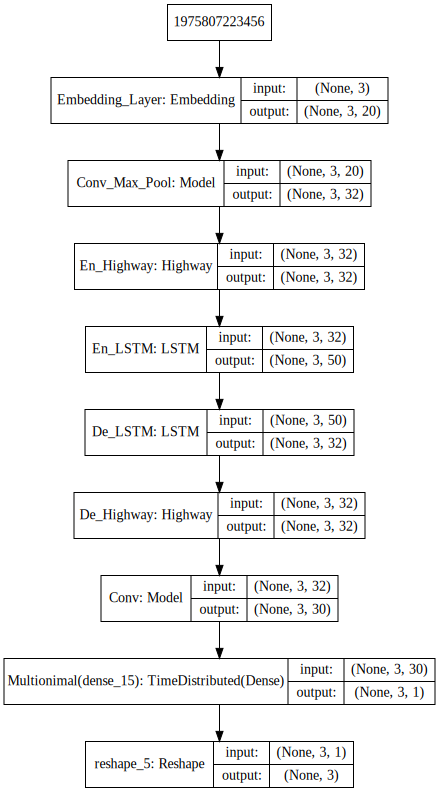

In [22]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [23]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_Layer (Embedding)  (None, 3, 20)             740       
_________________________________________________________________
Conv_Max_Pool (Model)        (None, 3, 32)             1430      
_________________________________________________________________
En_Highway (Highway)         (None, 3, 32)             2112      
_________________________________________________________________
En_LSTM (LSTM)               (None, 3, 50)             16600     
_________________________________________________________________
De_LSTM (LSTM)               (None, 3, 32)             10624     
_________________________________________________________________
De_Highway (Highway)         (None, 3, 32)             2112      
_________________________________________________________________
Conv (Model)                 (None, 3, 30)             2270      
__________

# Building Model

In [20]:
# Modify 'num_of_train_domains' and 'max_domain_length'
num_of_train_domains = 1200000
# max_domain_length = 47
max_domain_length = 3
char_vocab_size = 37
char_embed_size = 20

model = Sequential()
model.add(Embedding(char_vocab_size, char_embed_size, input_length=max_domain_length, name='Embedding_Layer'))

conv_input = Input(shape=(max_domain_length, char_embed_size))

# num_of_filters_bi = 20
# num_of_filters_tri = 10

conv_bi = Conv1D(20, 2, strides=1, padding='same')(conv_input)
conv_tri = Conv1D(10, 3, strides=1, padding='same')(conv_input)
conv_concat = concatenate([conv_bi, conv_tri], axis=2)
max_over_time_pooling = MaxPooling1D(pool_size=(conv_concat.get_shape()[1], ), padding='same')(conv_concat)
max_over_time_pooling = Reshape((1, 10+20))(max_over_time_pooling)

reshape_conv_bi = Permute((2, 1))(conv_bi)
reshape_conv_tri = Permute((2, 1))(conv_tri)
max_over_filter_pooling_bi = MaxPooling1D(pool_size=(reshape_conv_bi.get_shape()[1], ), padding='same')(reshape_conv_bi)
max_over_filter_pooling_tri = MaxPooling1D(pool_size=(reshape_conv_tri.get_shape()[1], ), padding='same')(reshape_conv_tri)

max_pooling_layers = list()
for idx in range(max_domain_length):
    sliced_bi = Lambda(lambda x: x[:, :, idx:idx+1])(max_over_filter_pooling_bi)
    sliced_tri = Lambda(lambda x: x[:, :, idx:idx+1])(max_over_filter_pooling_tri)
    
    single_pooling = concatenate([max_over_time_pooling, sliced_bi, sliced_tri], axis=2)
    max_pooling_layers.append(single_pooling)

conv_pooling = concatenate(max_pooling_layers, axis=1)
model.add(Model(input=conv_input, output=conv_pooling, name='Conv_Max_Pool'))
model.add(Highway(name='En_Highway'))
model.add(LSTM(50, return_sequences=True, name='En_LSTM'))


"""
for idx in range(max_domain_length):
    start_idx = idx
    
    if idx < max_domain_length-1:
        kernel_len_bi = 2
    else:
        kernel_len_bi = 1
    
    if idx < max_domain_length-2:
        kernel_len_tri = 3
    elif idx == max_domain_length-2:
        kernel_len_tri = 2
    else:
        kernel_len_tri = 1

    sliced_bi = Lambda(lambda x: x[:, start_idx:start_idx+2, :])(conv_input)
    conv_bi = Conv1D(20, kernel_len_bi, strides=1, padding='same')(sliced_bi)
    pool1_bi = MaxPooling1D(pool_size=(conv_bi.get_shape()[1],), padding='same')(conv_bi)
    re_pool1_bi = Reshape((1, 20))(pool1_bi)
    
    per_pool1_bi = Permute((2, 1))(re_pool1_bi)
    pool2_bi = MaxPooling1D(pool_size=(per_pool1_bi.get_shape()[1],), padding='same')(per_pool1_bi)
    re_pool2_bi = Reshape((1, 1))(pool2_bi)

    sliced_tri = Lambda(lambda x: x[:, start_idx:start_idx+kernel_len_tri, :])(conv_input)
    conv_tri = Conv1D(10, kernel_len_tri, strides=1, padding='same')(sliced_tri)
    pool1_tri = MaxPooling1D(pool_size=(conv_tri.get_shape()[1],), padding='same')(conv_tri)
    re_pool1_tri = Reshape((1, 10))(pool1_tri)

    per_pool1_tri = Permute((2, 1))(re_pool1_tri)
    pool2_tri = MaxPooling1D(pool_size=(per_pool1_tri.get_shape()[1],), padding='same')(per_pool1_tri)
    re_pool2_tri = Reshape((1, 1))(pool2_tri)

    conv_out = concatenate([re_pool1_bi, re_pool2_bi, re_pool1_tri, re_pool2_tri], axis=2)
    max_pooling_layers.append(conv_out)
"""

# conv_out_over_time = concatenate(max_pooling_layers, axis=1)
# model.add(Model(input=conv_input, output=conv_out_over_time))
# model.add(Highway())
# model.add(LSTM(50, return_sequences=True))
pass

C:\Users\JeongDo\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="Conv_Max_Pool", inputs=Tensor("in..., outputs=Tensor("co...)`


In [21]:
model.add(LSTM(32, return_sequences=True, name='De_LSTM'))
model.add(Highway(name='De_Highway'))

conv_input = Input(shape=(max_domain_length, 32))
conv_layers = list()

conv_bi = Conv1D(20, 2, strides=1, padding='same')(conv_input)
conv_tri = Conv1D(10, 3, strides=1, padding='same')(conv_input)
conv_out = concatenate([conv_bi, conv_tri], axis=2)

# conv_out_over_time = concatenate(conv_layers, axis=1)

model.add(Model(input=conv_input, output=conv_out, name='Conv'))
model.add(TimeDistributed(Dense(1), name='Multionimal'))
model.add(Reshape((max_domain_length,) ))

C:\Users\JeongDo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `Model` call to the Keras 2 API: `Model(name="Conv", inputs=Tensor("in..., outputs=Tensor("co...)`
  del sys.path[0]


In [5]:
arr_list = list()
for _ in range(1):
    a = np.random.choice(37, 3, replace=True)
    arr_list.append(a)

print(a.shape)
a = np.expand_dims(a, axis=0)
print(a.shape)

(3,)
(1, 3)


In [6]:
inp = model.input
# outputs = [layer.output for layer in model.layers]
# outputs = [model.layers[0].output, model.layers[1].get_output_at(0), model.layers[1].get_output_at(1)]
outputs = [model.layers[0].output]
functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]

# print(test_data)
print('start')
layer_outs1 = [func([a, 0.]) for func in functors]
# print(layer_outs)

W0823 18:28:54.626566 30040 deprecation_wrapper.py:119] From C:\Users\JeongDo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0823 18:28:54.629535 30040 deprecation_wrapper.py:119] From C:\Users\JeongDo\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



start


In [7]:
layer_outs1[0][0].shape

(1, 3, 20)

In [30]:
layer_outs1[0][0]

array([[[ 0.03429892, -0.01297622, -0.01703604,  0.00700948,
          0.0305844 , -0.04628355,  0.04063812, -0.00726911,
         -0.0154065 , -0.02788848, -0.04279457,  0.00851882,
         -0.04704212,  0.00402294,  0.04932003,  0.01286652,
          0.02716878, -0.00761076, -0.04266503,  0.02646952],
        [-0.01618462, -0.00267726,  0.02506658,  0.00699638,
         -0.03243098,  0.04445073, -0.02897645, -0.0258403 ,
          0.00337275, -0.01355617,  0.03063091,  0.04758449,
         -0.00013169, -0.01900047,  0.00961645,  0.03558942,
         -0.00989486, -0.00181296, -0.04358155, -0.02634844],
        [-0.01076403, -0.01578716, -0.04211899,  0.01627561,
         -0.02608323, -0.00339445,  0.0454053 , -0.045424  ,
         -0.01200674,  0.00022353, -0.00312232,  0.02169161,
         -0.01678878,  0.03723394, -0.02525081,  0.0086476 ,
          0.0151565 , -0.04145802, -0.03184142,  0.01958723]]],
      dtype=float32)

In [9]:
model.layers[1].get_input_at(0)

<tf.Tensor 'input_1:0' shape=(?, 3, 20) dtype=float32>

In [25]:
a

array([[26, 18, 20]])

In [29]:
K.function([model.layers[1].get_input_at(0), K.learning_phase()], [model.layers[1].get_output_at(0)])([layer_outs1[0][0], 0.])
# K.function([model.layers[0].input, K.learning_phase()], [model.layers[1].get_output_at(0)])([a, 0.])

UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1d_10/convolution}}]]
	 [[concatenate_17/concat/_177]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1d_10/convolution}}]]
0 successful operations.
0 derived errors ignored.

In [14]:
inp = model.input
# outputs = [model.layers[1].get_output_at(0), model.layers[1].get_output_at(1)]
outputs = [model.layers[1].get_output_at(0)]

# functors = [K.function([inp, K.learning_phase()], [out]) for out in outputs]
functors = list()
functors.append(K.function([model.layers[1].get_input_at(0), K.learning_phase()], [outputs[0]]))
# functors.append(K.function([model.layers[1].get_input_at(1), K.learning_phase()], [outputs[1]]))

print('start')
layer_outs = [func([layer_outs1[0][0], 0.]) for func in functors]
print(layer_outs[0])
print()
# print(layer_outs[1])

start


UnknownError: 2 root error(s) found.
  (0) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1d_2/convolution}}]]
	 [[concatenate_5/concat/_61]]
  (1) Unknown: Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[{{node conv1d_2/convolution}}]]
0 successful operations.
0 derived errors ignored.

In [382]:
outputs = list()
outputs.append(model.layers[0].output)
outputs.append(model.layers[1].get_output_at(1))
outputs.append(model.layers[2].output)
outputs.append(model.layers[3].output)
outputs.append(model.layers[4].output)
outputs.append(model.layers[5].output)
outputs.append(model.layers[6].get_output_at(0))
outputs.append(model.layers[7].output)

In [376]:
model.layers

In [58]:
# Modify 'num_of_train_domains' and 'max_domain_length'
num_of_train_domains = 1200000
max_domain_length = 47
char_vocab_size = 37
char_embed_size = 20

model = Sequential()
model.add(Embedding(char_vocab_size, char_embed_size, input_length=max_domain_length))

conv_input = Input(shape=(max_domain_length, char_embed_size))

num_of_filters_bi = 20
kernel_len_bi = 2
num_of_filters_tri = 10
kernel_len_tri = 3

conv_bi = Conv1D(num_of_filters_bi, kernel_len_bi, strides=1, padding='same')(conv_input)
pool_bi = MaxPooling1D([conv_bi.get_shape()[1]], padding='valid')(conv_bi)
per_pool_bi = Reshape((1, 20))(pool_bi)

conv_tri = Conv1D(num_of_filters_tri, kernel_len_tri, strides=1, padding='same')(conv_input)
pool_tri = MaxPooling1D([conv_tri.get_shape()[1]], padding='valid')(conv_tri)
per_pool_tri = Reshape((1, 10))(pool_tri)

"""
print(pool_bi.get_shape())
print(re_pool_bi.get_shape())
print(pool_tri.get_shape())
print(re_pool_tri.get_shape())
"""

conv_layers = list()
conv_out = concatenate([per_pool_bi, per_pool_tri], axis=2)
print(conv_out.get_shape())


model.add(Model(input=conv_input, output=conv_out))
# conv_tri = Conv1D(num_of_filters_tri, kernel_len_tri, strides=1, padding='same')(conv_input)
"""
pool_size = ()
conv_layers = list()

kernels=[2] * 20 + [3] * 10
for kernel_size in kernels:
    conv = Conv1D(32, kernel_size, strides=1, padding='same')(conv_input)
    permuted_conv = Permute((2, 1))(conv)
    pool = MaxPooling1D([permuted_conv.get_shape()[1]], strides=1, padding='valid')(permuted_conv)
    permuted_pool = Permute((2, 1))(pool)
    
    conv_layers.append(permuted_pool)

# conv_out = Concatenate()(conv_layers)
conv_out = concatenate(conv_layers, axis=2)
conv_model = Model(input=conv_input, output=conv_out)

model.add(conv_model)
"""
pass

(?, 20, 1)
(?, 10, 1)


TypeError: unhashable type: 'Dimension'

In [28]:
model.add(Reshape((max_domain_length, -1)))

In [6]:
# from keras.legacy.layers import Highway

In [29]:
model.add(Highway(input_shape=(30, ) ))

In [30]:
model.add(LSTM(50, input))

TypeError: `LSTM` can accept only 1 positional arguments ('units',), but you passed the following positional arguments: [50, <bound method Kernel.raw_input of <ipykernel.ipkernel.IPythonKernel object at 0x0000024AEE9D4240>>]

[[ 1  2  3]
 [ 4  5  6]
 [ 7  8  9]
 [10 11 12]]


[[ 1  2  3  7  8  9]
 [ 4  5  6 10 11 12]]


(4, 3)


# 모델 시각화

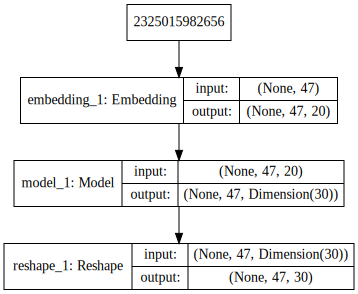

In [5]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

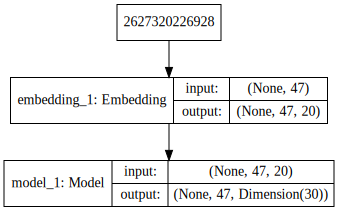

In [4]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [7]:
from dga_reader import load_data, DataReader

In [8]:
char_vocab, char_tensors, char_lens, max_word_length = load_data('.\\dga_data', 70)
train_reader = DataReader(char_tensors['train'], char_lens['train'], 128)

reading train
actual longest token length is: 70
size of char vocabulary: 40


In [20]:
tmp = None
for x, y in train_reader.iter():
    tmp = x
    break

In [26]:
tmp.shape

(128, 70)